# 라이브러리 불러오기

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

# 판별자(Discriminator)와 생성자(Generator) 모델 설계

In [5]:
latent_dim = 100

# 판별자(Discriminator) 클래스 설계
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256, 1),
            nn.Sigmoid() # 0~1 의 확률값을 내보낼 수 있게 한다.
        )
        
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)
        
        return output
    
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(input_dim, output_dim, normalize = True):
            layers = [nn.Linear(input_dim, output_dim)]
            
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            
            layers.append(nn.LeakyReLU(0.2, inplace = True))
            
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize = False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh() # -1 ~ 1까지의 값을 가질 수 있게 한다.
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28) # B x C x H x W
        return img
        
        

# MNIST 데이터셋 불러오기 및 전처리

In [6]:
transf_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(), # 데이터를  Tensor 형식으로 바꾸고 0~1 범위로 설정
    transforms.Normalize([0.5], [0.5]) #0~1이었던 범위를 -> -1~1로 재설정
])

train_dataset = datasets.MNIST(root = './dataset', train = True, download = True, transform = transf_train)
dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



# 모델 초기화 및 손실 함수, 학습률, 최적화 함수 설계

In [7]:
# 생성자와 판별자 초기화
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

generator = generator.to(device)
discriminator = discriminator.to(device)

# Loss Function
adverserial_loss = nn.BCELoss()
adverserial_loss = adverserial_loss.to(device)

# 학습률 설정
lr = 2 * 1e-4

# Generator와 Discriminator를 위한 최적화 함수
optimizer_G = optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))


# 모델 학습

In [8]:
import time

n_epochs = 200
sample_interval = 5000
start_time = time.time()

for epoch in range(n_epochs):
    for i, (images, _) in enumerate(dataloader):
        
        # 원본 이미지와 생성된 이미지에 대한 정답 레이블 생성
        real = torch.FloatTensor(images.size(0), 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(images.size(0), 1).fill_(0.0).to(device)
        
        real_images = images.to(device)
        
        # Generator 학습 시작
        optimizer_G.zero_grad()
        
        z = torch.normal(mean = 0, std = 1, size = (images.shape[0], latent_dim)) # 랜덤 noise Sampling
        z = z.to(device)
        
        generated_images = generator(z)
        
        g_loss = adverserial_loss(discriminator(generated_images), real)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Discriminator 학습 시작
        optimizer_D.zero_grad()
        
        real_loss = adverserial_loss(discriminator(real_images), real)
        fake_loss = adverserial_loss(discriminator(generated_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            save_image(generated_images.data[:25], f"{done}.png", nrow = 5, normalize = True)
            
    print(f"[Epoch {epoch} / {n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0 / 200] [D loss: 0.404588] [G loss: 1.267220] [Elapsed time: 16.63s]
[Epoch 1 / 200] [D loss: 0.451327] [G loss: 0.713870] [Elapsed time: 33.21s]
[Epoch 2 / 200] [D loss: 0.440894] [G loss: 0.699838] [Elapsed time: 49.10s]
[Epoch 3 / 200] [D loss: 0.664584] [G loss: 2.934170] [Elapsed time: 64.96s]
[Epoch 4 / 200] [D loss: 0.270181] [G loss: 1.110475] [Elapsed time: 80.66s]
[Epoch 5 / 200] [D loss: 0.300654] [G loss: 2.309675] [Elapsed time: 96.97s]
[Epoch 6 / 200] [D loss: 0.346662] [G loss: 1.875623] [Elapsed time: 112.82s]
[Epoch 7 / 200] [D loss: 0.736984] [G loss: 0.313666] [Elapsed time: 128.09s]
[Epoch 8 / 200] [D loss: 0.816966] [G loss: 0.285318] [Elapsed time: 143.92s]
[Epoch 9 / 200] [D loss: 0.210918] [G loss: 1.485866] [Elapsed time: 159.58s]
[Epoch 10 / 200] [D loss: 0.311587] [G loss: 1.262617] [Elapsed time: 175.08s]
[Epoch 11 / 200] [D loss: 0.161997] [G loss: 2.035187] [Elapsed time: 190.82s]
[Epoch 12 / 200] [D loss: 0.222669] [G loss: 1.424774] [Elapsed time

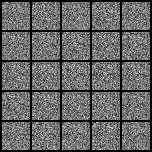

In [35]:
from IPython.display import Image

Image('0.png')

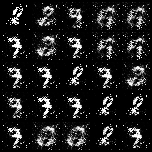

In [34]:
Image('5000.png')

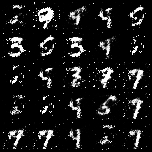

In [33]:
Image('25000.png')

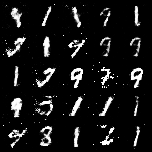

In [36]:
Image('60000.png')

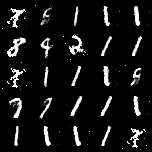

In [32]:
Image('90000.png')